In [48]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
# Define the airfoil function
n_ctr_pts = 10
n_times = 120
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [49]:

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = pts[:, 0]
    y = pts[:, 1]
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    """    plt.figure(figsize=(10, 5))
        plt.plot(x,y)
        plt.plot(xvals, yvals)
        plt.grid(True)"""
    return pts, Airfoil(x=xvals, y=yvals)

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [50]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = 1e5
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(0)
    return cl, cd

[[0.00126    0.015936   0.031107   0.043865   0.053683   0.059349
  0.05871    0.048243   0.02976    0.014147  ]
 [0.00090564 0.016017   0.031957   0.050216   0.059241   0.05893
  0.05265    0.042415   0.029338   0.        ]]


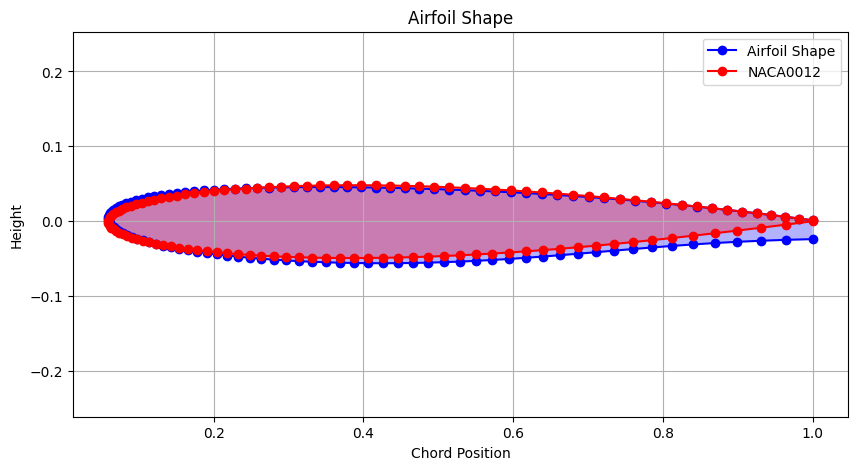

(0.04678715765476227, 0.014540676027536392)

In [51]:
naca = np.array([std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:])])
naca_ = [[0.00126  ,  0.015936   ,0.031107  , 0.043865,   0.053683 ,  0.03349,
  0.06871   , 0.048243 ,  0.02976  ,  0.054147  ],
 [0.00090564, 0.026017 ,  0.031957 ,  0.050216 ,  0.059241  , 0.05893,
  0.08265  ,  0.042415 ,  0.029338  , 0.023886  ]]

print(naca)
naca_pts, foil = airfoil(naca,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
naca_p, foil = airfoil(naca_,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
plot_foil(naca_p, std_points=[naca_pts[:, 0], naca_pts[:, 1]])
fitness(foil)

In [52]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = 1e5
    xf.max_iter = 100
    # Run XFoil analysis
    try:
        cl, cd, cm, cp = xf.a(0)
    except Exception as e:
        print(f"Error during XFoil analysis: {e}")
        cl, cd = -1.0, 100.0  # Penalize heavily for errors
    
    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return cl, -cd


In [53]:
# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.1)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

# Register evaluation function
toolbox.register("evaluate", evaluate_airfoil)

# Genetic Algorithm parameters
population_size = 50
max_generations = 3

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    # Generate random variations around NACA0012 as the baseline
    # Randomly perturb the heights of the control points
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    
    # Construct individual as per your structure
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    
    # Append individual to initial population
    initial_population.append(individual)

# Apply DEAP algorithms
pop = toolbox.population(n=population_size)
algorithms.eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)

# Select the best individual (pareto front)
best_individuals = tools.selBest(pop, k=1)
best_individual = best_individuals[0]

# Print results
best_cl, best_cd = evaluate_airfoil(best_individual)
print(f"Best Cl: {best_cl}, Best Cd: {-best_cd}")


gen	nevals
0  	50    
1  	39    
2  	37    
3  	36    
Best Cl: nan, Best Cd: nan


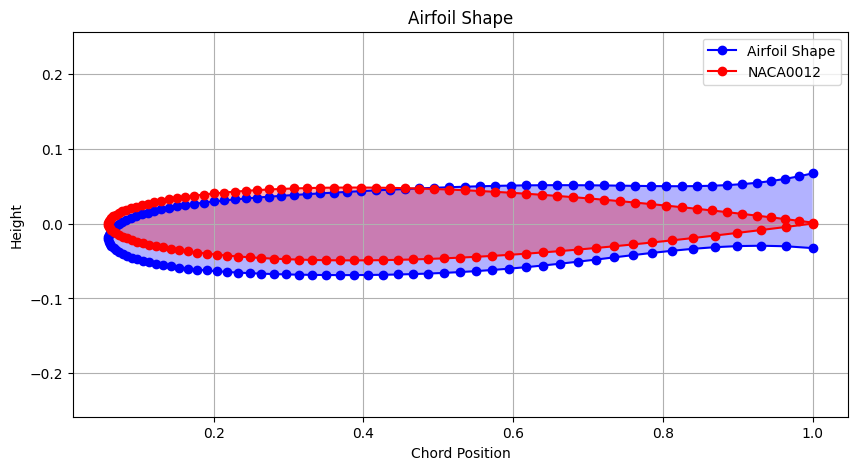

(nan, nan)

In [54]:
naca = np.array([std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:])])
best_indiv = np.array([best_individual[:n_ctr_pts], np.abs(best_individual[n_ctr_pts:])])
naca_pts, foil = airfoil(naca,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
naca_p, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
plot_foil(naca_p, std_points=[naca_pts[:, 0], naca_pts[:, 1]])
fitness(foil)